In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

import sys
import attr
import functools
import tqdm
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src')

from dataset import DatasetConfig, DatasetBuilder
from geometry import Rays
import os
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from collections import defaultdict
from typing import Callable, Dict, List, Tuple

import nerf
from nerf import NerfConfig, Nerf
import nerf_utils
import jax.numpy as jnp

import jax
from jax import jit, random
from trainer import Trainer, TrainerConfig
from flax import jax_utils
import trainer_utils
from nerf import NerfConfig, nerf_builder
import optax
from flax.training import train_state
import flax
from jax import lax

from IPython.display import display, clear_output

%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 10)

In [37]:
ds_config =  DatasetConfig(model_dir='../dataset/pinecone/sparse_8/0/',
                           images_dir='../dataset/pinecone/images_8/',
                           batch_from_single_image=True,
                           train_batch_size=1024,
                           test_batch_size=-1)
trainer_config = TrainerConfig(dataset_config=ds_config)
trainer = Trainer(trainer_config)
train_iter, eval_iter = trainer.create_dataset()

In [28]:
@jax.jit
def render_fn(rng, state, rays):
    return state.apply_fn(state.params, rng, rays, randomized=False)

def render_image(render_fn, rng, state, rays, chunk=8192):
    num_rays = rays.colors.shape[0]
    batch_size = num_rays // chunk
    batch_remainder = num_rays - batch_size * chunk
    counts = [chunk] * batch_size + [batch_remainder]
    index = np.cumsum([0] + counts)[:-1]
    
    colors_list = []
    depths_list = []
    _state = flax.jax_utils.unreplicate(state)
    for i, c in zip(index, counts):
        cur_rays = jax.tree_map(lambda x: x[i:i + c, :], rays)
        c_colors, c_depths, f_colors, f_depths  = render_fn(rng, _state, cur_rays)
        colors_list.append(c_colors)
        depths_list.append(c_depths)

    colors = jnp.concatenate(colors_list, axis=0)
    depths = jnp.concatenate(depths_list, axis=0)
    return colors.reshape((-1, 484, 3)), depths.reshape((-1, 484))

In [21]:
class TrainerDebug:
    """Class for training NeRF model."""

    def __init__(self, config: TrainerConfig):
        self._config = config
        self._rng = random.PRNGKey(20200823)
        self._state = None

    def create_train_state(self):
        self._rng, key = random.split(self._rng)
        model, params = nerf_builder(key, self._config.model_config)
        init_lr = self._config.optimizer_config.init_lr
        max_steps = self._config.optimizer_config.max_steps
        exponential_decay_scheduler = optax.exponential_decay(
            init_value=init_lr,
            transition_steps=max_steps,
            decay_rate=0.1)
        tx = optax.adam(exponential_decay_scheduler)
        state = train_state.TrainState.create(
            apply_fn=model.apply,
            params=params,
            tx=tx)
        return state

    def create_train_step(self):
        return jax.pmap(
            self._train_step_impl,
            axis_name='batch')

    def _train_step_impl(self, key, state, rays):
        """Perform a single training step."""
        def loss_fn(params):
            coarse_rgb, _, fine_rgb, fine_depth = state.apply_fn(params, key, rays)

            # Compute RGB loss.
            loss_coarse_rgb = trainer_utils.mse_loss(coarse_rgb, rays.colors)
            loss_fine_rgb = trainer_utils.mse_loss(coarse_rgb, rays.colors)
            loss_rgb = loss_coarse_rgb + loss_fine_rgb

            # Mask out invalid depth values.
            mask = ~jnp.isnan(rays.depths)
            depths_gt = jnp.where(mask, rays.depths, 0.)
            weights_depth = jnp.where(mask, rays.weights, 0.)

            # Compute depth loss.
            loss_depth = trainer_utils.mse_loss(fine_depth, depths_gt, weights_depth)
            loss_depth *= 0.1
        
            # Final loss.
            loss = loss_rgb + loss_depth

            metrics = {"loss_rgb": loss_rgb,
                       "loss_depth": loss_depth,
                       "loss": loss}

            # Add weight decay.
            weight_penalty_params = jax.tree_leaves(params)
            weight_decay = 1e-5
            weight_l2 = sum([jnp.sum(x ** 2)
                            for x in weight_penalty_params
                            if x.ndim > 1])
            weight_penalty = weight_decay * 0.5 * weight_l2
            loss = loss + weight_penalty
            return loss, metrics

        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, metrics), grads = grad_fn(state.params)
        # Re-use same axis_name as in the call to `pmap(...train_step...)` below.
        grads = lax.pmean(grads, axis_name='batch')
        metrics = lax.pmean(metrics, axis_name='batch')

        new_state = state.apply_gradients(grads=grads)
        return new_state, metrics

trainer_debug = TrainerDebug(TrainerConfig())
state = trainer_debug.create_train_state()
state = jax_utils.replicate(state)
train_step = trainer_debug.create_train_step()

In [40]:
losses = []

for step, rays in zip(range(int(5e5)), train_iter):
    key, trainer._rng = random.split(trainer._rng)
    keys = random.split(key, 1)
    state, metrics = train_step(keys, state, rays)
    loss = metrics["loss"]
    if jnp.isnan(loss):
        break
    losses.append(loss)
    if step % 10000 == 0:
        key, rng = random.split(trainer._rng)
        eval_rays = next(eval_iter)
        eval_img, eval_depth = render_image(render_fn, key, state, jax.tree_map(lambda x:x[0], eval_rays))
        plt.rcParams["figure.figsize"] = (10, 20)
        ax0 = plt.subplot(311)
        ax0.imshow(eval_img)
        ax1 = plt.subplot(312)
        ax1.imshow(eval_depth)
        ax2 = plt.subplot(313)
        ax2.imshow(eval_rays.colors.reshape((-1, 484, 3)))
        plt.tight_layout()
        plt.show()                                                                          
        clear_output(wait = True)

KeyboardInterrupt: 

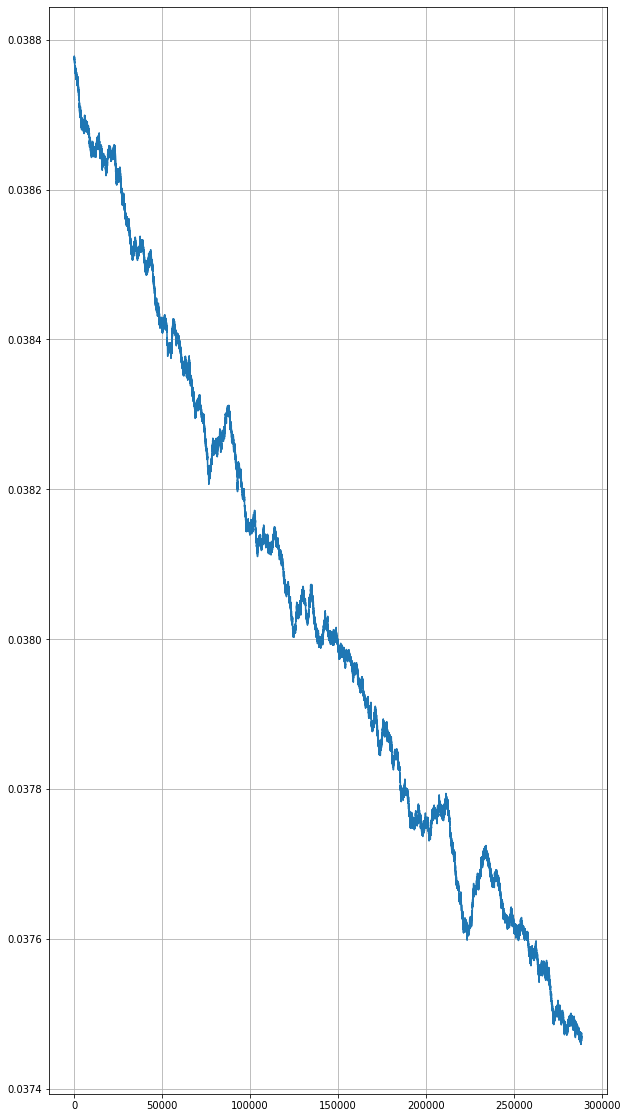

In [39]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(losses, 10000))
plt.grid('on')

In [19]:
import optax
import flax
from flax.training import train_state
import trainer_utils
from typing import Any, Callable

from flax import core
from flax import struct
from jax import lax, jit, random

rays = next(train_iter)

@flax.struct.dataclass
class TrainState:
    apply_fn: Callable = struct.field(pytree_node=False)
    optimizer: flax.optim.Optimizer

def create_train_state():
    rng = random.PRNGKey(20200823)
    key0, rng = random.split(rng)
    model, params = nerf.nerf_builder(key0, nerf.NerfConfig())
    optimizer = flax.optim.Adam(5e-4).create(params)
    state = TrainState(
        apply_fn=model.apply,
        optimizer=optimizer)
    return state

@jax.jit
def train_step(rng, state, rays, learning_rate=5e-4):
    """Perform a single training step."""
    rng, key = random.split(rng)

    def loss_fn(params):
        coarse_rgb, coarse_depth, fine_rgb, fine_depth = state.apply_fn(params, key, rays)

        loss_coarse_rgb = trainer_utils.mse_loss(coarse_rgb, rays.colors)
        loss_fine_rgb = trainer_utils.mse_loss(fine_rgb, rays.colors)
        loss_rgb = loss_coarse_rgb # + loss_fine_rgb

        mask = ~jnp.isnan(rays.depths)
        depths_gt = jnp.where(mask, rays.depths, 0.)
        weights_depth = jnp.where(mask, rays.weights, 0.)

        # loss_coarse_depth = trainer_utils.mse_loss(coarse_depth, depths_gt, weights_depth)
        loss_fine_depth = trainer_utils.mse_loss(fine_depth, depths_gt, weights_depth)
        loss_depth = loss_fine_depth
    
        loss = loss_rgb + loss_depth * 0.1
        
        # Add weight decay.
        weight_penalty_params = jax.tree_leaves(params)
        weight_decay = 0.0001
        weight_l2 = sum([jnp.sum(x ** 2)
                        for x in weight_penalty_params
                        if x.ndim > 1])
        weight_penalty = weight_decay * 0.5 * weight_l2
        return loss + weight_penalty


    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.optimizer.target)
    new_optimizer = state.optimizer.apply_gradient(grads, learning_rate=learning_rate)
    new_state = state.replace(optimizer=new_optimizer)
    return new_state, loss, grads

state = create_train_state()
rng = random.PRNGKey(1122546)

@jax.jit
def render_fn(rng, rays):
    return state.apply_fn(state.optimizer.target, rng, rays, randomized=False)

In [20]:
losses = []

for step, rays in zip(range(int(5e4)), train_iter):
    key, rng = random.split(rng)

    state, loss, grads = train_step(key, state, jax.tree_map(lambda x:x[0], rays))
    if jnp.isnan(loss):
        break
    losses.append(loss)
    if step % 5000 == 0:
        key, rng = random.split(rng)
        eval_rays = next(eval_iter)
        eval_img, eval_depth = render_image(render_fn, key, jax.tree_map(lambda x:x[0], eval_rays))
        plt.rcParams["figure.figsize"] = (10, 20)
        ax0 = plt.subplot(311)
        ax0.imshow(eval_img)
        ax1 = plt.subplot(312)
        ax1.imshow(eval_depth)
        ax2 = plt.subplot(313)
        ax2.imshow(eval_rays.colors.reshape((-1, 484, 3)))
        plt.tight_layout()
        plt.show()
        clear_output(wait = True)

RuntimeError: Resource exhausted: Out of memory while trying to allocate 10901915112 bytes.

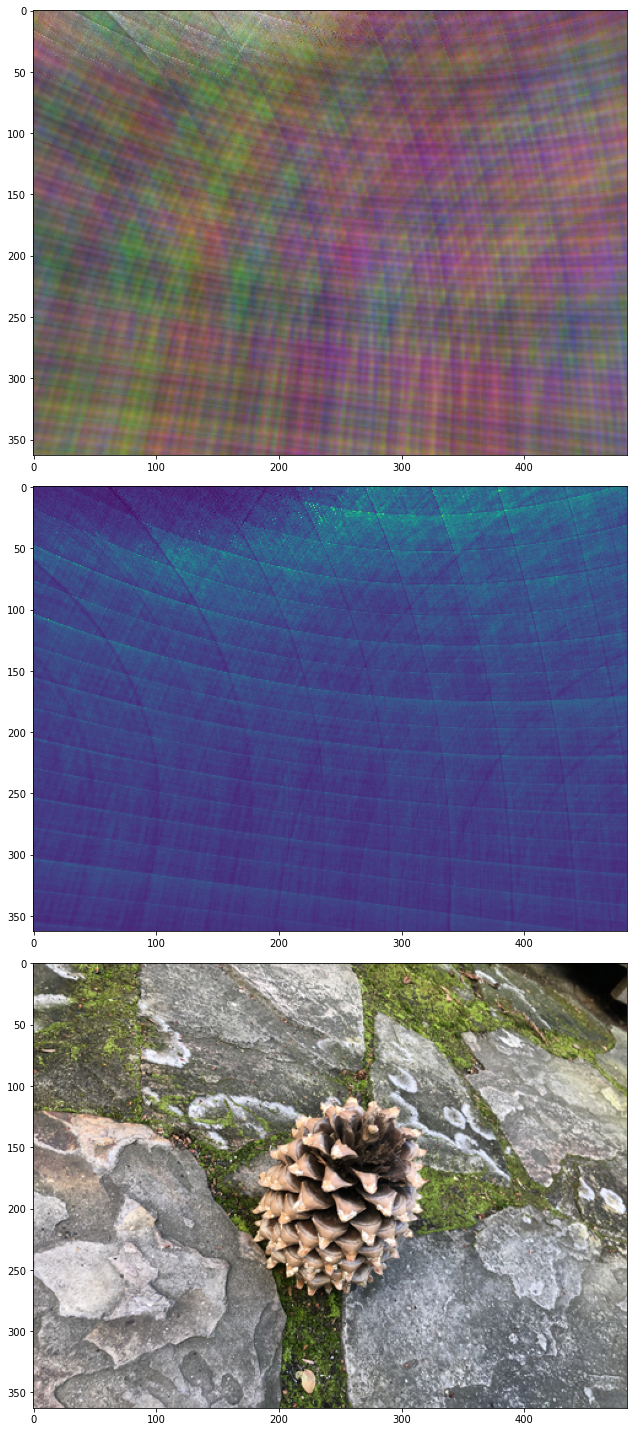

In [9]:
key, rng = random.split(rng)
eval_rays = next(eval_iter)
eval_img, eval_depth = render_image(render_fn, key, jax.tree_map(lambda x:x[0], eval_rays))
plt.rcParams["figure.figsize"] = (10, 20)
ax0 = plt.subplot(311)
ax0.imshow(eval_img)
ax1 = plt.subplot(312)
ax1.imshow(eval_depth)
ax2 = plt.subplot(313)
ax2.imshow(eval_rays.colors.reshape((-1, 484, 3)))
plt.tight_layout()
plt.show()

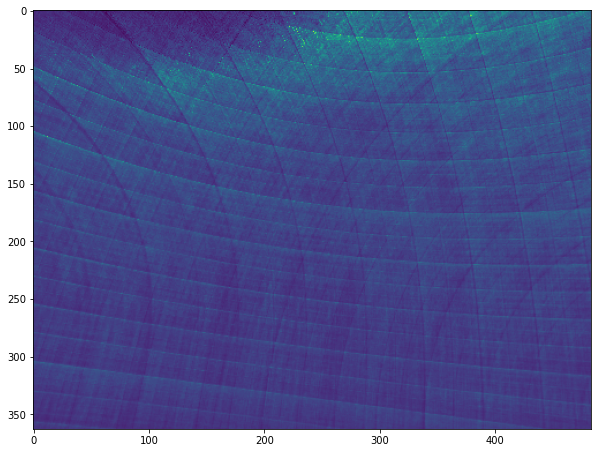

In [12]:
plt.imshow(eval_depth)

In [42]:
from flax.training import checkpoints

def restore_checkpoint(state, workdir):
    return checkpoints.restore_checkpoint(workdir, state)

def save_checkpoint(state, workdir):
    # get train state from the first replica
    state = jax.device_get(state)
    step = 500000
    checkpoints.save_checkpoint(workdir, state, step, keep=3)

save_checkpoint(state, "../models/")

In [15]:
loss

DeviceArray(0.02295545, dtype=float32)

In [53]:
state = restore_checkpoint(state, "./checkpoint_100000")

counts = [2048] * 5953 + [1024]
index = np.cumsum([0] + counts)[:-1]

coarse_colors_list = []
fine_colors_list = []

eval_rays = next(eval_iter)
for i, c in zip(index, counts):
    cur_rays = jax.tree_map(lambda x: x[0, i:i + c, :], eval_rays)
    coarse_colors, fine_colors = state.apply_fn(state.params, trainer._rng, cur_rays)
    coarse_colors_list.append(coarse_colors)
    fine_colors_list.append(fine_colors)

In [55]:
colors.shape

(12192768, 3)

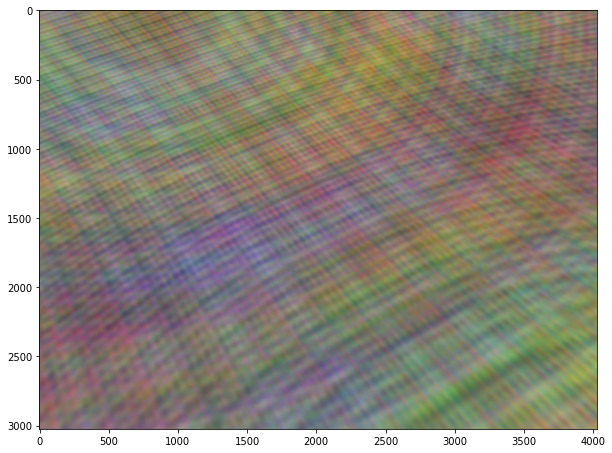

In [60]:
colors = jnp.concatenate(fine_colors_list, axis=0)
image = colors.reshape((-1, 4032, 3))
plt.imshow(image)

In [28]:
#state = jax_utils.unreplicate(states)
eval_rays = next(eval_iter)
_, fine_colors = state.apply_fn(state.params, trainer._rng, jax.tree_map(lambda x: x[0, :2048, :], eval_rays))

# image = fine_colors.reshape((-1, 4032, 3))
# plt.imshow(image)

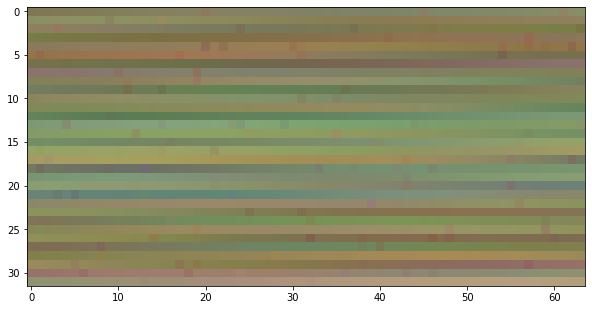

In [44]:
plt.imshow(fine_colors.reshape((-1, 64, 3)))

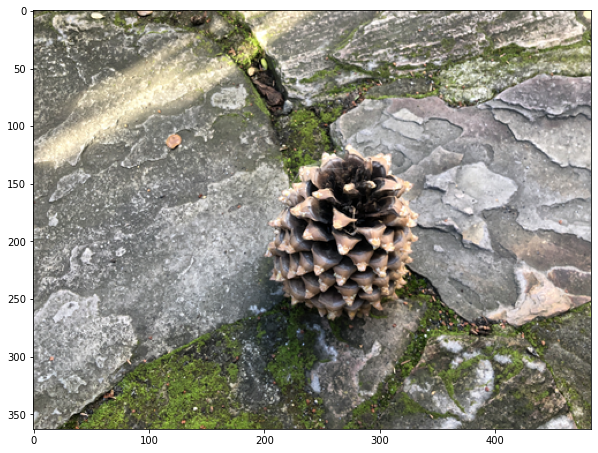

In [21]:
colors = np.copy(eval_rays.colors[0])
# colors[:2048, ...] = 0 #fine_colors

image = colors.reshape((-1, 484, 3))
plt.imshow(image)

In [30]:
fine_colors.shape

(2048, 3)

In [ ]:
rays = next(train_iter)

In [ ]:
state = trainer.create_train_state()

In [ ]:
p_train_step = jax.pmap(
    functools.partial(trainer.train_step, learning_rate_fn=None),
    axis_name='batch')

In [ ]:
keys = random.split(trainer._rng, 1)
states = jax_utils.replicate(state)
new_state, metrics = p_train_step(keys, states, rays)

In [ ]:
coarse_rgb, fine_rgb = state.apply_fn(state.params, trainer._rng, jax.tree_map(lambda x: x[0], rays))

In [ ]:
plt.imshow(coarse_rgb.reshape((64, -1)))

In [ ]:
@attr.s(frozen=True, auto_attribs=True)
class NerfBuilder:
    config: NerfConfig

    def build(self, rng: jnp.ndarray, rays: Rays):
        model = Nerf(self.config)
        key1, key2, rng = random.split(rng, num=3)
        init_params = model.init(
            key1, rng=key2, rays=rays)
        return model, init_params

rng = random.PRNGKey(0)
rays_local = jax.tree_map(lambda x:x[0], rays)
model, init_params = NerfBuilder(NerfConfig()).build(rng, rays_local)
coarse_rgb, fine_rgb = model.apply(init_params, rng, rays_local)

In [ ]:
import ml_collections

In [ ]:
@attr.s(frozen=True, auto_attribs=True)
class Foo:
    a: int = 0
    b: int = 1

In [ ]:
foo = Foo()
asdict(foo)

In [ ]:
from attr import asdict

In [ ]:
cfg = ml_collections.ConfigDict()
cfg.float_field = 12.6
cfg.integer_field = 123
cfg.another_integer_field = 234
cfg.nested = ml_collections.ConfigDict()
cfg.nested.string_field = 'tom'

print(cfg.integer_field)  # Prints 123.
print(cfg['integer_field'])  # Prints 123 as well.

In [ ]:
cfg

In [ ]:
coarse_rgb

In [ ]:
EPS = 1e-10

def volumetric_rendering(points_rgb, points_sigma, points_z, dirs, white_bkgd=True):
    dists = points_z[..., 1:] - points_z[..., :-1]
    dists = jnp.concatenate([dists, 1e10 * jnp.ones_like(dists[..., :1])], axis=-1)
    dists = dists * jnp.linalg.norm(dirs, axis=-1, keepdims=True)

    dists_sigma = points_sigma[..., 0] * dists
    alpha = 1.0 - jnp.exp(-dists_sigma)

    transmit = jnp.exp(-jnp.cumsum(dists_sigma[:, :-1], axis=-1))
    transmit = jnp.concatenate([jnp.ones_like(transmit[:, :1]), transmit], axis=-1)
    weights = alpha * transmit
    
    rgb = jnp.sum(weights[..., jnp.newaxis] * points_rgb, axis=1)
    depth = jnp.sum(weights * points_z, axis=1, keepdims=True)
    
    acc = jnp.sum(weights, axis=-1, keepdims=True)
    disp = acc / (depth + EPS)
    if white_bkgd:
        rgb = rgb + (1. - acc)
    return rgb, disp, acc, weights

points_rgb = random.uniform(rng, (64, 100, 3)) / 1000
points_sigma = random.uniform(rng, (64, 100, 1)) / 1000
rgb, disp, acc, weights = nerf_utils.volumetric_rendering(points_rgb, points_sigma, points_z, rays.directions)

In [ ]:
rgb

In [ ]:
import functools

from flax import jax_utils

num_rays = rays.origins.shape[0]
num_bins = 100
bins = jnp.linspace(0.001, 1000, num_bins)
bins = jnp.broadcast_to(bins, (num_rays, num_bins))
weights = jnp.ones_like(bins)
# sampler_fn = jit(functools.partial(nerf_utils.sample_along_rays,
#                                    100,
#                                    randomized=True))
sampler_fn = functools.partial(nerf_utils.sample_along_rays,
                               num_samples=100,
                               randomized=True)
points, points_z = sampler_fn(rng, rays, bins, weights)
encode = nerf_utils.positional_encoding(points, 0, 10)

encode.shape

In [ ]:
points_z.shape

In [ ]:
encode = nerf_utils.positional_encoding(rays.directions[:, jnp.newaxis, :], 0, 10)

encode.shape

In [ ]:
rays.directions.shape